<a href="https://colab.research.google.com/github/ndeekshith/CNN_Tiny_vgg/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing all the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from pathlib import Path
import time
from tqdm.auto import tqdm
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy

from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# My cnn model with tiny vgg architecture
class MyStreetFoodModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_height: int, image_width: int, dropout_rate: float = 0.5):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        with torch.no_grad():
            dummy_input = torch.randn(1, input_shape, image_height, image_width)
            dummy_output_conv1 = self.conv_block_1(dummy_input)
            dummy_output_conv2 = self.conv_block_2(dummy_output_conv1)
            flattened_size = dummy_output_conv2.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=flattened_size, out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
# Creating the custom image dataset using torch
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Setting model to gpu , device agnostic form
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Giving the image height width and channels
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 3

In [ ]:
# Giving the data path
data_root = Path("/content/drive/MyDrive/CV/popular_street_foods/dataset")

In [ ]:
# Choosing the hyperparameters
NUM_CLASSES = 20 # as outut class have 20 labels
BATCH_SIZE = 32
LEARNING_RATE = 0.001 # Initial learning rate
EPOCHS = 50
HIDDEN_UNITS = 16
TRAIN_SPLIT_RATIO = 0.8
DROPOUT_RATE = 0.4
WEIGHT_DECAY = 1e-4 # L2 regularization term as normal
EARLY_STOPPING_PATIENCE = 7
LR_SCHEDULER_PATIENCE = 3
LR_SCHEDULER_FACTOR = 0.1

In [ ]:
# --- Data Preprocessing, Splitting, and DataLoaders (More Augmentation) --- to get more data
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# (Dataset loading and splitting logic - same as previous script)
if not data_root.exists() or not data_root.is_dir():
    print(f"Error: Dataset root directory '{data_root.resolve()}' not found or is not a directory.")
    print("Creating dummy dataset structure for demonstration...")
    (data_root / "classA").mkdir(parents=True, exist_ok=True)
    (data_root / "classB").mkdir(parents=True, exist_ok=True)
    try:
        Image.new('RGB', (100, 100), color = 'red').save(data_root / "classA" / "dummy1.jpg")
        Image.new('RGB', (100, 100), color = 'blue').save(data_root / "classA" / "dummy2.jpg")
        Image.new('RGB', (100, 100), color = 'green').save(data_root / "classB" / "dummy3.jpg")
        Image.new('RGB', (100, 100), color = 'yellow').save(data_root / "classB" / "dummy4.jpg")
        print(f"Dummy dataset created at {data_root.resolve()}")
    except Exception as e:
        print(f"Could not create dummy images: {e}")
        exit()

all_image_paths = []
all_labels = []
class_names = sorted([d for d in os.listdir(data_root) if os.path.isdir(data_root / d)])
NUM_CLASSES = len(class_names)
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}

if NUM_CLASSES == 0: print(f"Error: No class subdirectories found in {data_root.resolve()}."); exit()
print(f"Found {NUM_CLASSES} classes: {class_names}")

for class_name in class_names:
    class_path = data_root / class_name
    label = class_to_idx[class_name]
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            all_image_paths.append(str(class_path / img_file))
            all_labels.append(label)

if not all_image_paths: print(f"Error: No images found in the subdirectories of {data_root.resolve()}."); exit()

combined = list(zip(all_image_paths, all_labels)); random.seed(42); random.shuffle(combined)
all_image_paths[:], all_labels[:] = zip(*combined)
num_total_samples = len(all_image_paths)
num_train_samples = int(TRAIN_SPLIT_RATIO * num_total_samples)
train_paths, train_labels = all_image_paths[:num_train_samples], all_labels[:num_train_samples]
test_paths, test_labels = all_image_paths[num_train_samples:], all_labels[num_train_samples:]

train_dataset = CustomImageDataset(train_paths, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_paths, test_labels, class_to_idx, test_transform)

print(f"Total samples: {num_total_samples}")
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Found 20 classes: ['arepas', 'bánh_mì', 'burger', 'churros', 'crepes', 'currywurst', 'empanadas', 'falafel', 'fish_and_chips', 'gelato', 'hot_dog', 'kebab_(shish_kebab)', 'pad_thai', 'pani_puri', 'pizza_slice', 'poutine', 'pretzel', 'samosas', 'shawarma', 'tacos']
Total samples: 3704
Training samples: 2963, Testing samples: 741


In [ ]:
# --- 4. Instantiate Model, Loss, Optimizer, LR Scheduler ---
model = MyStreetFoodModel(input_shape=IMAGE_CHANNELS,
                          hidden_units=HIDDEN_UNITS,
                          output_shape=NUM_CLASSES,
                          image_height=IMAGE_HEIGHT,
                          image_width=IMAGE_WIDTH,
                          dropout_rate=DROPOUT_RATE).to(device) # Pass dropout_rate
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY) # Added weight_decay
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min', # Monitors test_loss
                              factor=LR_SCHEDULER_FACTOR,
                              patience=LR_SCHEDULER_PATIENCE,
                              verbose=True)
model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


MyStreetFoodModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential

In [ ]:
# Create DataLoaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True, # Shuffle again at data loading stage for epochs
                              num_workers=2)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=2)

# ---  Instantiate Model, Loss Function, and Optimizer ---
model = MyStreetFoodModel(input_shape=IMAGE_CHANNELS,
                          hidden_units=HIDDEN_UNITS,
                          output_shape=NUM_CLASSES, # Ensure this is correct
                          image_height=IMAGE_HEIGHT,
                          image_width=IMAGE_WIDTH).to(device)

In [ ]:
# Setting the lossfunction and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [ ]:
# Training loop to train our model
def train_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module,
               optimizer: optim.Optimizer, device: torch.device, scaler=None):
    model.train()
    train_loss = 0
    correct_predictions = 0
    total_samples = 0

    for X, y in dataloader:
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if scaler:  # Mixed precision
            with torch.cuda.amp.autocast():
                y_pred_logits = model(X)
                loss = loss_fn(y_pred_logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        with torch.no_grad():
            predicted = y_pred_logits.argmax(dim=1)
            correct_predictions += (predicted == y).sum().item()
            total_samples += y.size(0)

    return train_loss / len(dataloader), correct_predictions / total_samples


def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, device: torch.device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)

            test_loss += loss.item()
            predicted = test_pred_logits.argmax(dim=1)
            correct_predictions += (predicted == y).sum().item()
            total_samples += y.size(0)

    return test_loss / len(dataloader), correct_predictions / total_samples


# --------------------------
# Begin Training Loop
# --------------------------

print(f"\nTraining on device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Training model for {EPOCHS} epochs...\n{'='*70}")

results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}


for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    start_time = time.time()

    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device, scaler)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch: {epoch + 1:>2}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
          f"Time: {epoch_time:.2f}s")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

print("="*70)
print("Training complete!")



Training on device: Tesla T4
Training model for 50 epochs...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch:  1/50 | Train Loss: 2.9807 | Train Acc: 0.0641 | Test Loss: 2.9587 | Test Acc: 0.0823 | Time: 13.71s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  2/50 | Train Loss: 2.9113 | Train Acc: 0.0979 | Test Loss: 2.8612 | Test Acc: 0.1377 | Time: 13.45s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  3/50 | Train Loss: 2.8514 | Train Acc: 0.1259 | Test Loss: 2.7968 | Test Acc: 0.1687 | Time: 13.13s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  4/50 | Train Loss: 2.8159 | Train Acc: 0.1347 | Test Loss: 2.7688 | Test Acc: 0.1687 | Time: 13.35s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  5/50 | Train Loss: 2.7694 | Train Acc: 0.1471 | Test Loss: 2.6961 | Test Acc: 0.1700 | Time: 13.49s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  6/50 | Train Loss: 2.7380 | Train Acc: 0.1671 | Test Loss: 2.6614 | Test Acc: 0.1808 | Time: 13.44s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  7/50 | Train Loss: 2.6838 | Train Acc: 0.1789 | Test Loss: 2.6124 | Test Acc: 0.2146 | Time: 13.35s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  8/50 | Train Loss: 2.6653 | Train Acc: 0.1897 | Test Loss: 2.5856 | Test Acc: 0.2078 | Time: 13.45s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch:  9/50 | Train Loss: 2.6144 | Train Acc: 0.1954 | Test Loss: 2.5528 | Test Acc: 0.2132 | Time: 13.43s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch: 10/50 | Train Loss: 2.5845 | Train Acc: 0.2116 | Test Loss: 2.5208 | Test Acc: 0.2200 | Time: 13.23s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch: 11/50 | Train Loss: 2.5653 | Train Acc: 0.2099 | Test Loss: 2.5140 | Test Acc: 0.2267 | Time: 13.23s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch: 12/50 | Train Loss: 2.5432 | Train Acc: 0.2227 | Test Loss: 2.4815 | Test Acc: 0.2335 | Time: 13.23s


<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-64-1947070944>:26: FutureWarni

Epoch: 13/50 | Train Loss: 2.5072 | Train Acc: 0.2342 | Test Loss: 2.4517 | Test Acc: 0.2483 | Time: 13.02s
Epoch: 14/50 | Train Loss: 2.5169 | Train Acc: 0.2194 | Test Loss: 2.4547 | Test Acc: 0.2308 | Time: 12.31s
Epoch: 15/50 | Train Loss: 2.4876 | Train Acc: 0.2366 | Test Loss: 2.4498 | Test Acc: 0.2537 | Time: 12.27s
Epoch: 16/50 | Train Loss: 2.4463 | Train Acc: 0.2487 | Test Loss: 2.4412 | Test Acc: 0.2429 | Time: 12.27s
Epoch: 17/50 | Train Loss: 2.4351 | Train Acc: 0.2386 | Test Loss: 2.4801 | Test Acc: 0.2335 | Time: 11.75s
Epoch: 18/50 | Train Loss: 2.4265 | Train Acc: 0.2541 | Test Loss: 2.4276 | Test Acc: 0.2524 | Time: 11.87s
Epoch: 19/50 | Train Loss: 2.4270 | Train Acc: 0.2514 | Test Loss: 2.3776 | Test Acc: 0.2645 | Time: 12.24s
Epoch: 20/50 | Train Loss: 2.4112 | Train Acc: 0.2670 | Test Loss: 2.4007 | Test Acc: 0.2645 | Time: 12.40s
Epoch: 21/50 | Train Loss: 2.4060 | Train Acc: 0.2595 | Test Loss: 2.4003 | Test Acc: 0.2483 | Time: 12.43s
Epoch: 22/50 | Train Loss: 2


--- Testing with Sample Images ---
Image: 0070.jpg
Predicted class: currywurst (Confidence: 0.1628)


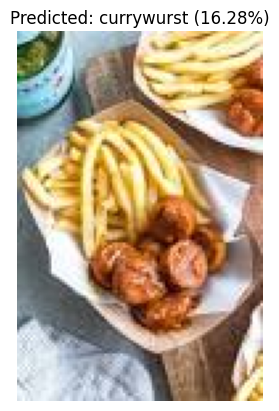

------------------------------
Image: 0041.jpg
Predicted class: fish_and_chips (Confidence: 0.4480)


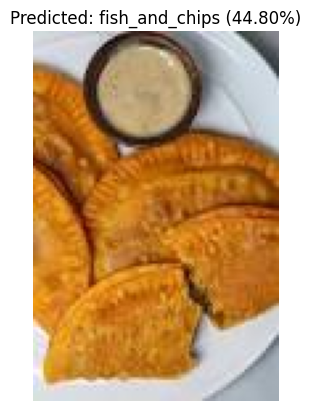

------------------------------
Image: 0045.jpg
Predicted class: pizza_slice (Confidence: 0.3150)


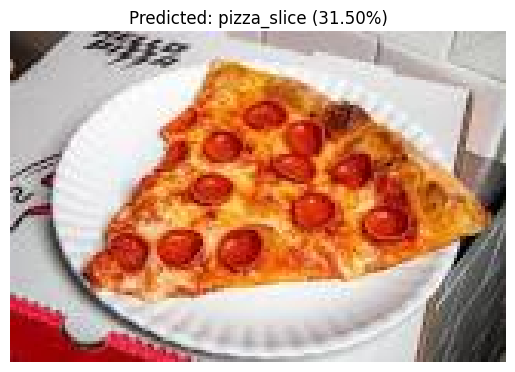

------------------------------


In [ ]:
# Getting the prediction
def predict_single_image(model_to_test: nn.Module,
                         image_path: str,
                         transform: transforms.Compose,
                         class_names_list: list,
                         device_to_use: torch.device):
    """Predicts the class of a single image."""
    model_to_test.eval()
    try:
        img = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None, None

    # Apply transformations and add batch dimension
    img_transformed = transform(img).unsqueeze(0).to(device_to_use)

    with torch.no_grad():
        output_logits = model_to_test(img_transformed)
        probabilities = torch.softmax(output_logits, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        predicted_class_name = class_names_list[predicted_class_idx]
        confidence = probabilities[0][predicted_class_idx].item()

    return predicted_class_name, confidence, img


print("\n--- Testing with Sample Images ---")

sample_image_paths_to_test = []
if test_paths:
    sample_image_paths_to_test = random.sample(test_paths, min(3, len(test_paths)))
elif all_image_paths:
     sample_image_paths_to_test = random.sample(all_image_paths, min(3, len(all_image_paths)))
if not sample_image_paths_to_test and (data_root / "classA" / "dummy1.jpg").exists():
    sample_image_paths_to_test.append(str(data_root / "classA" / "dummy1.jpg"))
    if (data_root / "classB" / "dummy3.jpg").exists():
         sample_image_paths_to_test.append(str(data_root / "classB" / "dummy3.jpg"))


if not sample_image_paths_to_test:
    print("No sample images found to test.")
else:


    for img_path_str in sample_image_paths_to_test:
        predicted_class, confidence, original_image = predict_single_image(
            model_to_test=model,
            image_path=img_path_str,
            transform=test_transform,
            class_names_list=class_names,
            device_to_use=device
        )

        if predicted_class is not None:
            print(f"Image: {Path(img_path_str).name}")
            print(f"Predicted class: {predicted_class} (Confidence: {confidence:.4f})")
            # Optional: Display the image
            plt.imshow(original_image)
            plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
            plt.axis("off")
            plt.show()
        print("-" * 30)


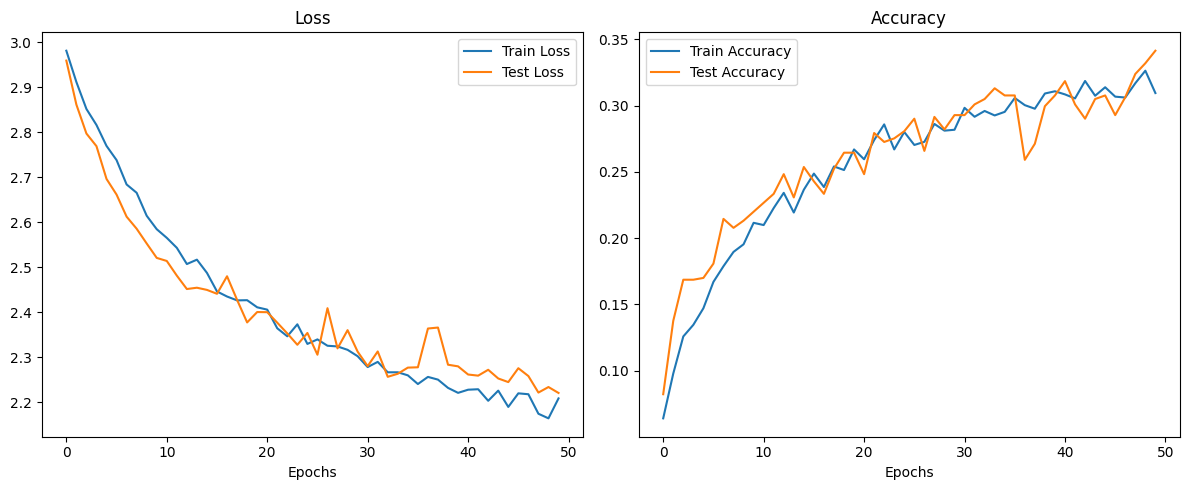

In [ ]:
#Getting the loss and accuracy curves
import matplotlib.pyplot as plt
try:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["test_loss"], label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label="Train Accuracy")
    plt.plot(results["test_acc"], label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not found. Skipping plotting.")


--- Generating Confusion Matrix ---


Calculating predictions for confusion matrix:   0%|          | 0/24 [00:00<?, ?it/s]

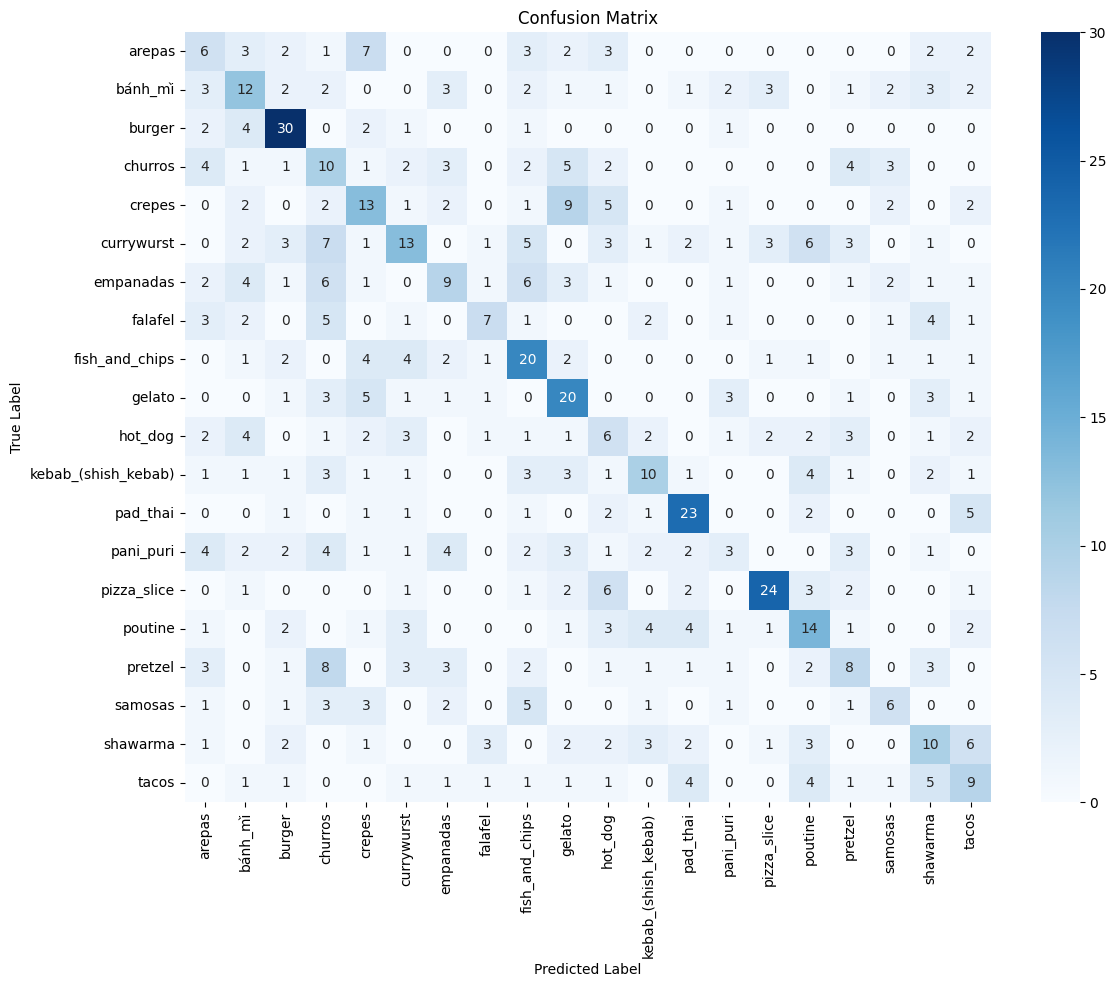

In [ ]:
# drawing the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
print("\n--- Generating Confusion Matrix ---")
if len(test_dataloader) > 0 : # Ensure test_dataloader is not empty
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Calculating predictions for confusion matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted_indices = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_indices.cpu().numpy())

    if not y_true or not y_pred:
        print("Not enough data in the test set to generate a confusion matrix.")
    else:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(max(10, NUM_CLASSES // 1.5), max(8, NUM_CLASSES // 2))) # Adjust size based on num classes
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
else:
    print("Test dataloader is empty. Cannot generate confusion matrix.")